In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pickle
from sklearn import svm
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import confusion_matrix, auc, roc_curve, classification_report
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style("whitegrid")

In [53]:
df = pd.read_csv('diabetes_rev0.csv')

In [54]:
df.head(10)

,hashID,diagnosisType,currentAge,diagnosisAge,yearsLivingWithDiabetes,upload.count,upload.nDaysWithData,diagnosis_bin,mean_null,sum_null,cbg_null,pump_null,smbg_null,device_null,wizard_null,bolus_null,basal_null,cgm_null
0,92c2847d30b6514ac8a6385f04b3bf3c92ee87a8b89cb8...,type2,59,20,38,1,1,0,0.516129,16,1,1,0,1,1,1,1,1
1,6b720ecfc94a90f7c75a39f80a97eac27969ca95a2e6fb...,type2,65,45,19,22,14,0,0.516129,16,1,1,0,1,1,1,1,1
2,e0ef840bd07fc79f10b8e21a7f6f3d53ef3b7594d94ec0...,type1,32,15,17,6,5,1,0.064516,2,0,0,0,0,0,0,0,1
3,8974377383af45404d560543b58749b240c78885ca0710...,type1,47,14,32,1,1,1,0.354839,11,0,1,0,0,1,1,1,1
4,f92417af60cc16f254600f310df4d15d4a50973de26223...,type2,62,53,8,1,1,0,0.516129,16,1,1,0,1,1,1,1,1
5,b96eee9a57d57b6fcf3d9326ae8372bd196706da93caa4...,type1,4,4,0,29,14,1,0.516129,16,1,1,0,1,1,1,1,1
6,8a2da88b5859a2cf5635a3ca35da1d3456fadd4272f9e3...,type1,26,7,19,1,1,1,0.451613,14,0,1,1,0,1,1,1,1
7,73d26fe0f67c6731617902c43fba936e5ff55c36bd12ff...,type1,18,8,10,2294,25,1,0.516129,16,0,1,1,1,1,1,1,1
8,db17945b2ce9557cb456172f94d43ea170d045d92282b8...,type1,45,5,40,1215,20,1,0.516129,16,0,1,1,1,1,1,1,1
9,1476f11455ec5e9c2d2d6392545178d8c6184257134b45...,type2,39,23,16,1,1,0,0.516129,16,0,1,1,1,1,1,1,1


In [55]:
t2 = df['diagnosisType']=='type2' # people with type 2
t1 = df['diagnosisType']=='type1' # people with type 1

In [56]:
X = df[['diagnosisAge', 'pump_null', 'bolus_null', 'device_null', 'cgm_null', 'cbg_null', 'upload.nDaysWithData']]
y = df['diagnosis_bin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_sample(X_train, y_train)

In [6]:
clf = svm.SVC()

gamma_range = np.logspace(-100, 5, 20)
C_range = np.logspace(-3, 4, 10)
kernel_range = ['linear']

param_grid = dict(gamma=gamma_range, C=C_range, kernel=kernel_range)

grid = GridSearchCV(clf, param_grid, cv=3, scoring='recall', verbose=1, n_jobs=4)
grid.fit(X_ros, y_ros)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=4)]: Done 600 out of 600 | elapsed:  1.4min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'gamma': array([1.00000e-100, 3.35982e-095, 1.12884e-089, 3.79269e-084,
       1.27427e-078, 4.28133e-073, 1.43845e-067, 4.83293e-062,
       1.62378e-056, 5.45559e-051, 1.83298e-045, 6.15848e-040,
       2.06914e-034, 6.95193e-029, 2.33572e-023, 7.84760e-018,
       2.63665e-012, 8.8586...+00,
       7.74264e+00, 4.64159e+01, 2.78256e+02, 1.66810e+03, 1.00000e+04]), 'kernel': ['linear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=1)

In [7]:
predictions = grid.predict(X_test)
print(grid.best_params_)
print('Train Score:', grid.score(X_ros, y_ros))
print('Test Score:', grid.score(X_test, y_test))

{'C': 0.21544346900318845, 'gamma': 1e-100, 'kernel': 'linear'}
Train Score: 0.9169960474308301
Test Score: 0.9466666666666667


Confusion matrix 1
[[15  7]
 [ 4 71]]
Confusion Matrix 2
[[0.68 0.32]
 [0.05 0.95]]


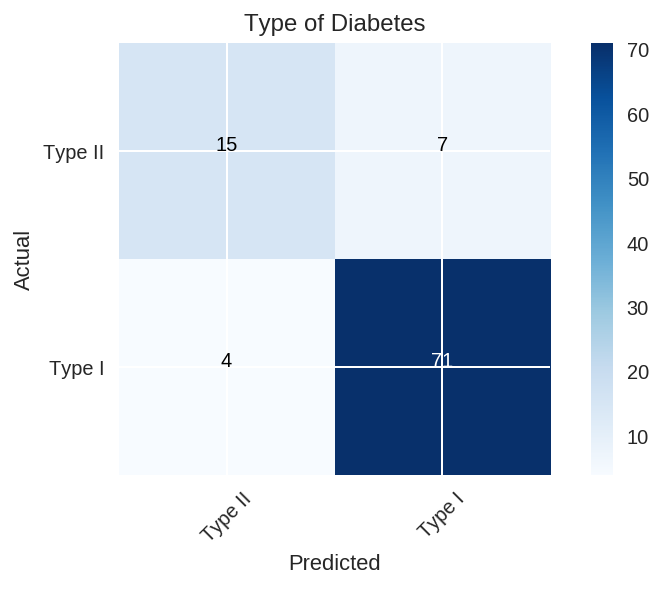

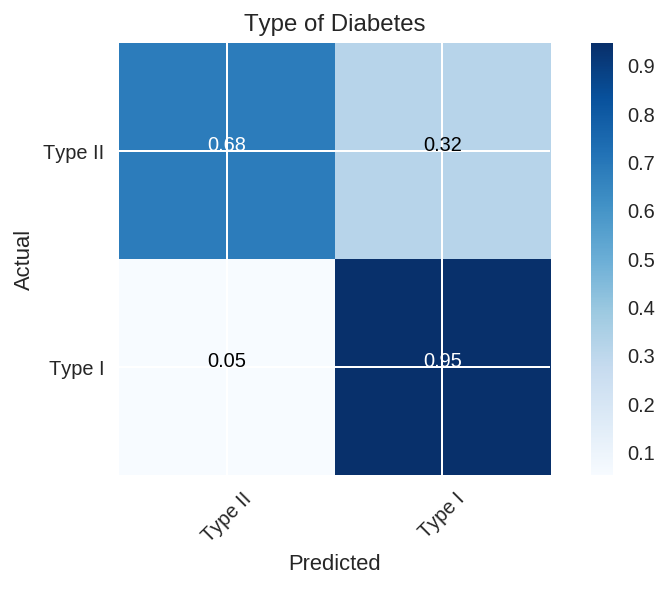

In [8]:
# Plotting final confusion matrix

cm = confusion_matrix(y_test, predictions)
classes = ['Type II', 'Type I']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Confusion Matrix 2")
    else:
        print('Confusion matrix 1')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

cnf_matrix = confusion_matrix(y_test, predictions)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Type of Diabetes')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                      title='Type of Diabetes')

plt.show()

Sensitivity:  
$$ \frac{TP}{P} = \frac{TP}{TP + FN} = \frac{71}{71 + 7} = 0.91 $$

Specificity:  
$$ \frac{TN}{N} = \frac{TN}{TN + FP} = \frac{15}{15 + 4} = 0.79 $$

In [9]:
y_score = grid.decision_function(X_test)

In [10]:
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=0)
area = auc(tpr, fpr)
area

0.9366666666666666

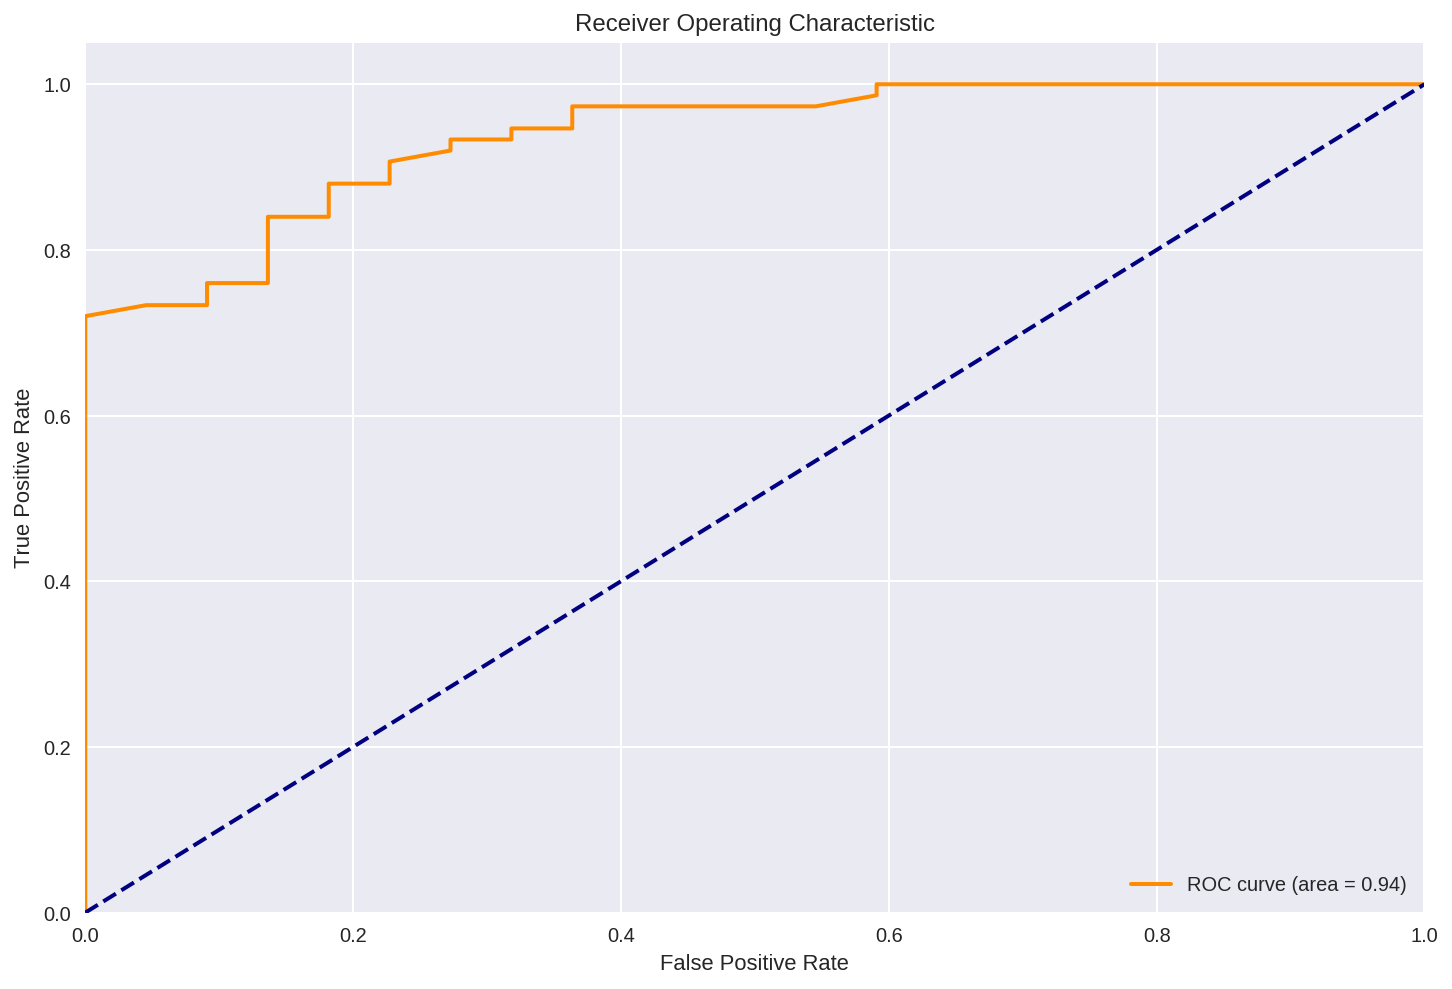

In [11]:
plt.figure(figsize=(12,8))
lw = 2
plt.plot(tpr, fpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

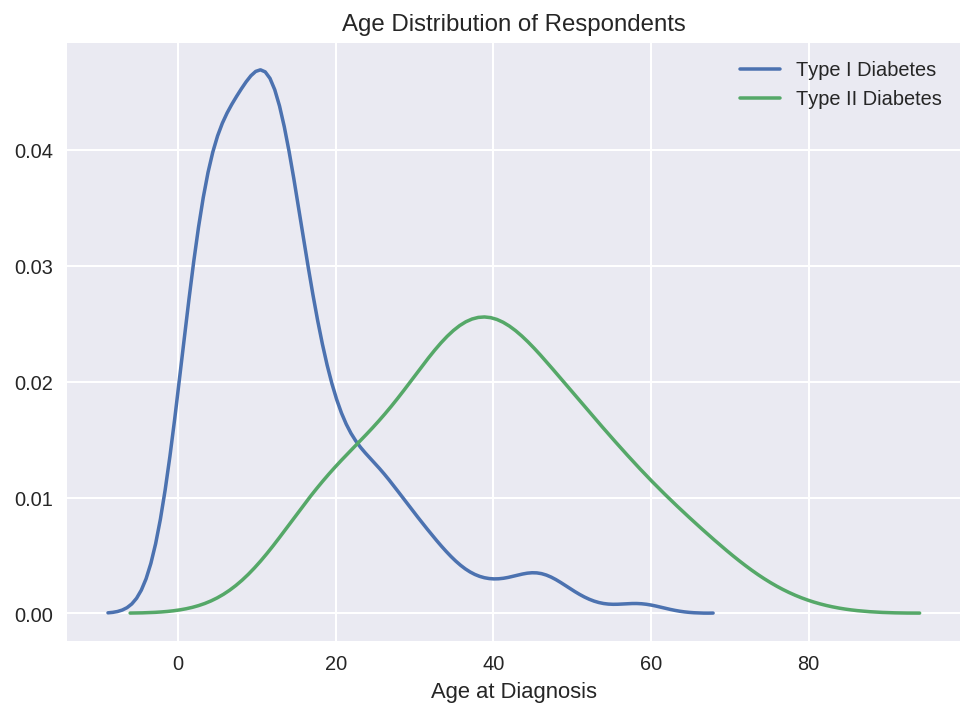

In [12]:
x = df[t1]['diagnosisAge']
y = df[t2]['diagnosisAge']

sns.set_context(context='notebook')
sns.distplot(x, label='Type I Diabetes', hist=False, kde=True)
sns.distplot(y, label='Type II Diabetes', hist=False, kde=True)
plt.title('Age Distribution of Respondents')
plt.xlabel('Age at Diagnosis')
plt.show()

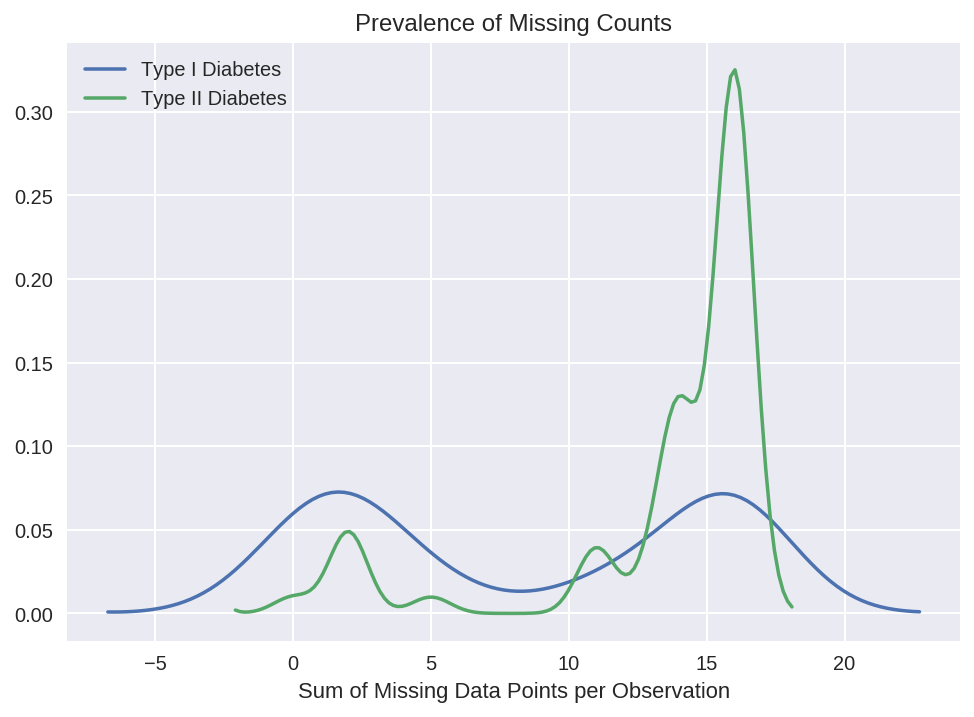

In [13]:
x = df[t1]['sum_null']
y = df[t2]['sum_null']

sns.set_context(context='notebook')
sns.distplot(x, label='Type I Diabetes', hist=False, kde=True)
sns.distplot(y, label='Type II Diabetes', hist=False, kde=True)
plt.title('Prevalence of Missing Counts')
plt.xlabel('Sum of Missing Data Points per Observation')
plt.show()

In [14]:
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.79      0.68      0.73        22
          1       0.91      0.95      0.93        75

avg / total       0.88      0.89      0.88        97



In [57]:
diab_svm = svm.SVC(C=0.21544346900318845,
                   gamma=1e-100,
                   kernel='linear',
                   )
diab_svm.fit(X_ros, y_ros)

SVC(C=0.21544346900318845, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-100, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [58]:
y_hat = diab_svm.predict(X_test)
print(classification_report(y_test ,y_hat))

             precision    recall  f1-score   support

          0       0.79      0.68      0.73        22
          1       0.91      0.95      0.93        75

avg / total       0.88      0.89      0.88        97



In [59]:
features = ['diagnosisAge', 'pump_null', 'bolus_null', 'device_null', 'cgm_null', 'cbg_null', 'upload.nDaysWithData']

/home/craig/anaconda3/envs/dsi/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


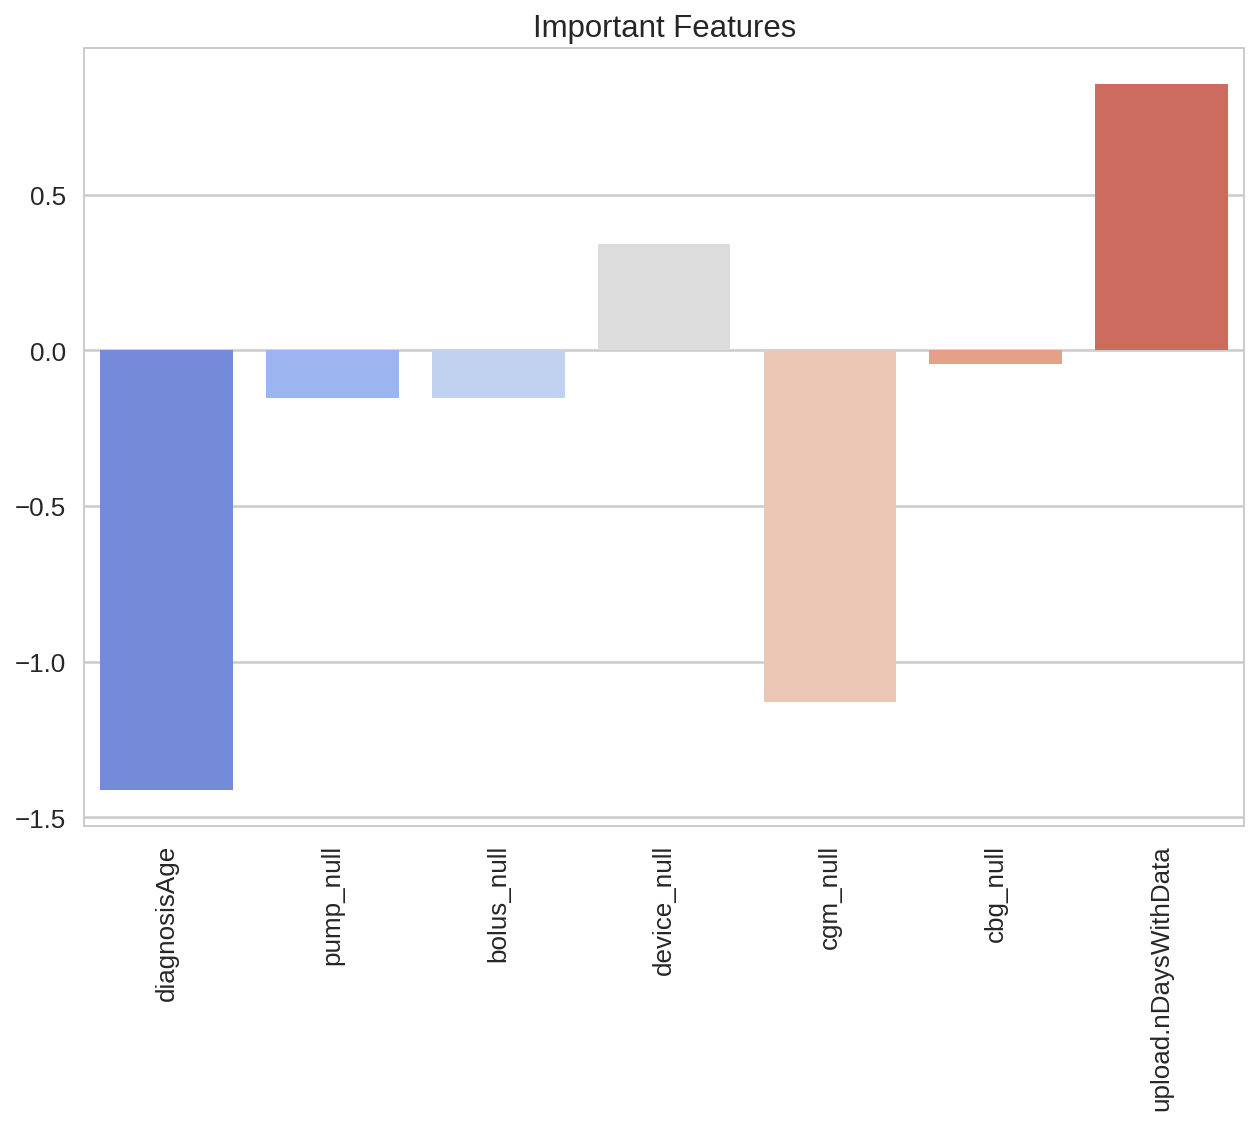

In [72]:
sns.set_context("talk")
sns.barplot(features, diab_svm.coef_[0], palette='coolwarm')
plt.xticks(rotation='vertical')
plt.title("Important Features")
plt.show()

In [67]:
# Save to file in the current working directory
pkl_filename = 'diab_svm.pkl'  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(diab_svm, file)